In [1]:
from utilities import files
import numpy as np
from scipy.io import loadmat
import os.path as op
from matplotlib.pylab import plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [5]:
data_path = "/home/mszul/datasets/explicit_implicit_beta/derivatives/lagged_coherence"
mat_files = files.get_files(data_path, "sub-", "coherence.mat")[2]
mat_files.sort()

In [6]:
visual_mat_files = [i for i in mat_files if "vis" in i]
motor_mat_files = [i for i in mat_files if "mot" in i]

In [7]:
loadmat(visual_mat_files[0])["lagged_coh"].shape

(11, 191, 81)

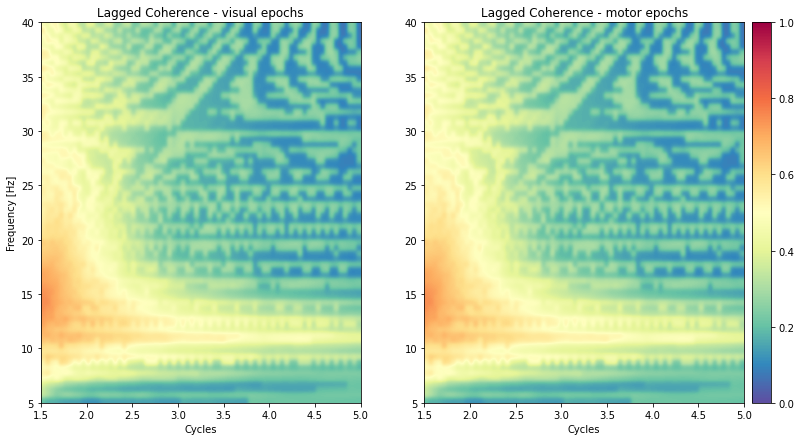

In [8]:
foi = np.linspace(5, 100, num=191)
cycles = np.linspace(1, 5, num=81)

freq_cut = np.where(foi>=40)[0][0]
cycl_cut = np.where(cycles<=1.5)[0][-1]
# freq_cutoff_ix = 97


lc_vis = []
for i in visual_mat_files:
    ar = loadmat(i)["lagged_coh"]
    ar = np.nanmean(ar[:, :freq_cut, cycl_cut:], axis=0)
    ar_max = np.nanmax(ar)
    ar = ar / ar_max
    lc_vis.append(ar)
lc_vis_m = np.nanmean(lc_vis, axis=0)

lc_mot = []
for i in motor_mat_files:
    ar = loadmat(i)["lagged_coh"]
    ar = np.nanmean(ar[:, :freq_cut, cycl_cut:], axis=0)
    ar_max = np.nanmax(ar)
    ar = ar / ar_max
    lc_mot.append(ar)
lc_mot_m = np.nanmean(lc_vis, axis=0)

max_val = np.nanmax(np.vstack([lc_mot_m, lc_vis_m]))

f, ax = plt.subplots(1, 2, figsize=(15, 7), facecolor="white")

ax[0].set_title("Lagged Coherence - visual epochs")
ax[0].set_xlabel("Cycles")
ax[0].set_ylabel("Frequency [Hz]")
ax[0].imshow(
    lc_vis_m,
    interpolation="gaussian",
    origin="lower",
    aspect="auto",
    cmap="Spectral_r",
    vmin=0,
    vmax=1,
    extent=[cycles[cycl_cut], cycles[-1], foi[0], foi[freq_cut]]
)

ax[1].set_title("Lagged Coherence - motor epochs")
ax[1].set_xlabel("Cycles")
LC_cb = ax[1].imshow(
    lc_mot_m,
    interpolation="gaussian",
    origin="lower",
    aspect="auto",
    cmap="Spectral_r",
    vmin=0,
    vmax=1,
    extent=[cycles[cycl_cut], cycles[-1], foi[0], foi[freq_cut]]
)

f.colorbar(LC_cb, ax=ax.ravel().tolist(), pad=0.01)
plt.savefig("/scratch/BURST_PAPER/updated_supplementary_lagged_coherence.svg")

In [9]:
beta_range = np.where((foi >= 13) & (foi <= 30))[0]
alpha_range = np.where((foi >= 7) & (foi <= 12))[0]
B_VIS = np.vstack([np.nanmean(i[beta_range,:], axis=0) for i in lc_vis])
B_MOT = np.vstack([np.nanmean(i[beta_range,:], axis=0) for i in lc_mot])

A_VIS = np.vstack([np.nanmean(i[alpha_range,:], axis=0) for i in lc_vis])
A_MOT = np.vstack([np.nanmean(i[alpha_range,:], axis=0) for i in lc_mot])

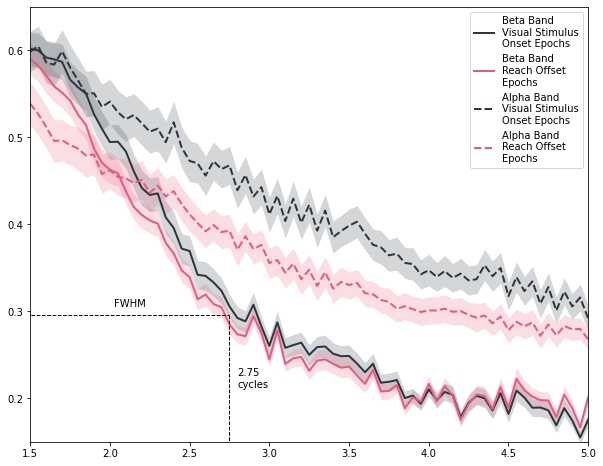

In [10]:
f, ax = plt.subplots(1, 1, figsize=(10, 8), facecolor="white")
ax.plot(cycles[cycl_cut:], np.mean(B_VIS, axis=0), lw=2, color="#2C363F", label="Beta Band\nVisual Stimulus\nOnset Epochs")
ax.fill_between(
    cycles[cycl_cut:],
    np.mean(B_VIS, axis=0) - np.std(B_VIS, axis=0) / np.sqrt(37),
    np.mean(B_VIS, axis=0) + np.std(B_VIS, axis=0) / np.sqrt(37),
    lw=0, color="#2C363F", alpha=0.2
)
ax.plot(cycles[cycl_cut:], np.mean(B_MOT, axis=0), lw=2, color="#E75A7C", label="Beta Band\nReach Offset\nEpochs")
ax.fill_between(
    cycles[cycl_cut:],
    np.mean(B_MOT, axis=0) - np.std(B_MOT, axis=0) / np.sqrt(37),
    np.mean(B_MOT, axis=0) + np.std(B_MOT, axis=0) / np.sqrt(37),
    lw=0, color="#E75A7C", alpha=0.2
)

ax.plot(cycles[cycl_cut:], np.mean(A_VIS, axis=0), "--", lw=2, color="#2C363F", label="Alpha Band\nVisual Stimulus\nOnset Epochs")
ax.fill_between(
    cycles[cycl_cut:],
    np.mean(A_VIS, axis=0) - np.std(A_VIS, axis=0) / np.sqrt(37),
    np.mean(A_VIS, axis=0) + np.std(A_VIS, axis=0) / np.sqrt(37),
    lw=0, color="#2C363F", alpha=0.2
)

ax.plot(cycles[cycl_cut:], np.mean(A_MOT, axis=0), "--", lw=2, color="#E75A7C", label="Alpha Band\nReach Offset\nEpochs")
ax.fill_between(
    cycles[cycl_cut:],
    np.mean(A_MOT, axis=0) - np.std(A_MOT, axis=0) / np.sqrt(37),
    np.mean(A_MOT, axis=0) + np.std(A_MOT, axis=0) / np.sqrt(37),
    lw=0, color="#E75A7C", alpha=0.2
)


mn_B = np.mean([np.mean(B_VIS, axis=0), np.mean(B_MOT, axis=0)], axis=0)
FWHM_ix = np.where(mn_B <= mn_B.max()/2)[0][0]
x_targ = cycles[cycl_cut:][FWHM_ix]
y_targ = mn_B[FWHM_ix]

ax.plot([0, x_targ], [y_targ, y_targ], "--", color="black", lw=1)
ax.plot([x_targ, x_targ], [0, y_targ], "--", color="black", lw=1)
ax.annotate("FWHM", xy=((x_targ+1.5)/2, y_targ+0.01), ha="center")
ax.annotate("2.75\ncycles", xy=(x_targ+0.05, (y_targ+.15)/2), va="center", ha="left")

ax.set_ylim(0.15, 0.65)
ax.set_xlim(cycles[cycl_cut], cycles[-1])
ax.legend()
plt.savefig("/scratch/BURST_PAPER/updated_supplementary_lagged_coherence_alpha_beta.svg")